## Importing necessary libraries

In [1]:
# Standard Library Imports
import os                 
import random              
import shutil              
import time                
import warnings            
import math                

# Data Manipulation Libraries
import pandas as pd        
import numpy as np         

# Visualization
import matplotlib.pyplot as plt  

# PyTorch Core Libraries
import torch               
import torch.nn as nn      
import torch.nn.functional as F  

import torch.optim as optim          
from torch.nn.parameter import Parameter  
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset  

# PyTorch Vision Libraries
import torchvision.transforms as transforms  
import torchvision.datasets as datasets      
import torchvision.models as torchmodels     
from torchvision.utils import make_grid      

# Image Processing
from PIL import Image     

# Device Configuration
device = "cuda" if torch.cuda.is_available() else "cpu"

## Dataset Class

In [2]:
class WikiArtCombinedDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Dataset for the combined WikiArt dataset with artist, genre, and style labels.
        
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        # Keep track of valid indices after filtering out corrupted files
        self.valid_indices = self._validate_files()
        
    def _validate_files(self):
        """Validate all files in the dataset and return list of valid indices.""" ## This was added because some files in the dataset were found to be corrupted
        valid_indices = []
        for idx in range(len(self.annotations)):
            # Get file path from the 'file' column
            img_path = self.annotations.iloc[idx, 0]
            
            # Extract the style/category from the path (first part before the slash)
            category = img_path.split('/')[0]
            
            # Construct the full path based on your directory structure
            # Assuming the structure is root_dir/category/category/image_filename
            full_path = os.path.join(self.root_dir, category, category, os.path.basename(img_path))
            
            if os.path.exists(full_path):
                try:
                    # Try to open the image to check if it's valid
                    with Image.open(full_path) as img:
                        img.verify()  # Verify the image
                    valid_indices.append(idx)
                except (IOError, OSError) as e:
                    print(f"Corrupted image at index {idx}, path: {full_path}, Error: {e}")
            else:
                print(f"Missing image at index {idx}, path: {full_path}")
                
        print(f"Found {len(valid_indices)} valid images out of {len(self.annotations)}")
        return valid_indices
        
    def __len__(self):
        return len(self.valid_indices)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Map the clean index to the original dataset index
        original_idx = self.valid_indices[idx]
        
        # Get the file path and labels from CSV
        img_path = self.annotations.iloc[original_idx, 0]  # First column (file)
        artist_label = self.annotations.iloc[original_idx, 1]  # Second column (artist)
        genre_label = self.annotations.iloc[original_idx, 2]   # Third column (genre)
        style_label = self.annotations.iloc[original_idx, 3]   # Fourth column (style)
        
        # Extract the category from the path (assuming format like "Category/image.jpg")
        category = img_path.split('/')[0]
        
        # Construct the full path with the correct structure
        full_path = os.path.join(self.root_dir, category, category, os.path.basename(img_path))
        
        try:
            # Load image
            image = Image.open(full_path).convert('RGB')
            
            if self.transform:
                image = self.transform(image)
                
            # Return image and all three labels
            return image, (artist_label, genre_label, style_label)
        except (IOError, OSError) as e:
            # This should not happen since we've validated the files,
            # but just in case there's a race condition or file is modified
            print(f"Error loading previously validated image {full_path}: {e}")
            # Return a placeholder image
            placeholder = torch.zeros(3, 224, 224) if self.transform else Image.new('RGB', (224, 224), color='black')
            return placeholder, (artist_label, genre_label, style_label)

In [3]:
# Create the full dataset with the combined CSV file
full_dataset = WikiArtCombinedDataset(
    csv_file='/kaggle/input/artwork/merged_wikiart_dataset.csv',
    root_dir='/kaggle/input/lesssgooooowikiart',
    transform=None  # We'll apply transforms after splitting
)

Found 15983 valid images out of 15983


## Data Augmentation and Transformation techniques

### The change in augmentation techniques along with change of optimizer and LR schedule lead to an improvement of 7 percent. Below are the specific changes that were made in data augmentation and transformations

### Old Augmentation and Data Transformation code

In [4]:
# ## Data augmentation and transformatin technique given in the reference paper  
# ## https://arxiv.org/abs/2110.11852

# # Define transforms for training
# train_transforms = transforms.Compose([
#     transforms.RandomResizedCrop(224),  # ResNet expects 224x224 input
#     transforms.RandomHorizontalFlip(),  # Data augmentation
#     transforms.RandomRotation(10),      # Data augmentation
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
# ])

# # Define transforms for testing and validation
# test_transforms = transforms.Compose([
#     transforms.Resize(256),             # Resize the shorter side to 256
#     transforms.CenterCrop(224),         # Center crop to 224x224
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
# ])


### New Augmentation and Data Transformation code

In [5]:
# Enhanced data augmentation for based on latest State-of-the-Art practices
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),  # Increased rotation range
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.3, hue=0.1),  # Color jittering (important for artwork)
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # Random translation and scaling
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),  # Perspective changes
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.25)  # Random erasing after normalization
])


# Define transforms for testing and validation (same as original)
test_transforms = transforms.Compose([
    transforms.Resize(256),             # Resize the shorter side to 256
    transforms.CenterCrop(224),         # Center crop to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])


In [6]:
# Split the dataset into train, validation, and test sets (80:10:10)
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

# Create the splits with fixed seed for reproducibility
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, 
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# Create dataset wrappers to apply the appropriate transforms
class TransformWrapper(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image, labels = self.dataset[idx]
        if self.transform:
            image = self.transform(image)
        return image, labels

# Apply the transforms to each split
train_dataset_transformed = TransformWrapper(train_dataset, train_transforms)
val_dataset_transformed = TransformWrapper(val_dataset, test_transforms)  # Using test transforms for validation
test_dataset_transformed = TransformWrapper(test_dataset, test_transforms)

# Create a custom collate function to handle any issues 
def collate_fn(batch):
    # Filter out None values if any
    batch = list(filter(lambda x: x is not None and not (isinstance(x[0], torch.Tensor) and x[0].sum() == 0), batch))
    if len(batch) == 0:
        return None
    return torch.utils.data.dataloader.default_collate(batch)

# Create dataloaders
batch_size = 32

train_loader = DataLoader(
    train_dataset_transformed,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset_transformed,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    test_dataset_transformed,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

# Model code

## Different Attention Mechanisms

In [7]:
# ============================= SE Layer =============================

# https://github.com/moskomule/senet.pytorch/blob/master/senet/se_module.py
class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

# ============================= ECA Mechansim =============================
class eca_layer(nn.Module):
    """Constructs a ECA module.
    Args:
        channel: Number of channels of the input feature map
        k_size: Adaptive selection of kernel size
        source: https://github.com/BangguWu/ECANet
    """
    def __init__(self, channel, k_size=3):
        super(eca_layer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv1d(1, 1, kernel_size=k_size, padding=(k_size - 1) // 2, bias=False) 
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x: input features with shape [b, c, h, w]
        b, c, h, w = x.size()

        # feature descriptor on the global spatial information
        y = self.avg_pool(x)

        # Two different branches of ECA module
        y = self.conv(y.squeeze(-1).transpose(-1, -2)).transpose(-1, -2).unsqueeze(-1)

        # Multi-scale information fusion
        y = self.sigmoid(y)

        return x * y.expand_as(x)

# ============================= CBAM Module =============================
class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_planes, eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None
        
    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max']):
        super(ChannelGate, self).__init__()
        self.gate_channels = gate_channels
        self.mlp = nn.Sequential(
            Flatten(),
            nn.Linear(gate_channels, gate_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(gate_channels // reduction_ratio, gate_channels)
        )
        self.pool_types = pool_types
        
    def forward(self, x):
        channel_att_sum = None
        for pool_type in self.pool_types:
            if pool_type == 'avg':
                avg_pool = F.avg_pool2d(x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp(avg_pool)
            elif pool_type == 'max':
                max_pool = F.max_pool2d(x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp(max_pool)
            elif pool_type == 'lp':
                lp_pool = F.lp_pool2d(x, 2, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp(lp_pool)
            elif pool_type == 'lse':
                # LSE pool
                lse_pool = logsumexp_2d(x)
                channel_att_raw = self.mlp(lse_pool)
                
            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum = channel_att_sum + channel_att_raw
                
        scale = torch.sigmoid(channel_att_sum).unsqueeze(2).unsqueeze(3).expand_as(x)
        return x * scale

def logsumexp_2d(tensor):
    tensor_flatten = tensor.view(tensor.size(0), tensor.size(1), -1)
    s, _ = torch.max(tensor_flatten, dim=2, keepdim=True)
    outputs = s + (tensor_flatten - s).exp().sum(dim=2, keepdim=True).log()
    return outputs

class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat((torch.max(x, 1)[0].unsqueeze(1), torch.mean(x, 1).unsqueeze(1)), dim=1)

class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size = 7
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size-1) // 2, relu=False)
        
    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = torch.sigmoid(x_out)  # broadcasting
        return x * scale

class CBAM(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max'], no_spatial=False):
        super(CBAM, self).__init__()
        self.ChannelGate = ChannelGate(gate_channels, reduction_ratio, pool_types)
        self.no_spatial = no_spatial
        if not no_spatial:
            self.SpatialGate = SpatialGate()
            
    def forward(self, x):
        x_out = self.ChannelGate(x)
        if not self.no_spatial:
            x_out = self.SpatialGate(x_out)
        return x_out

In [8]:
# ============================= ConvLSTM Cell =============================
class ConvLSTMCell_layer(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size=(3, 3), bias=False):
        """
        Initialize ConvLSTM cell.
        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """
        super(ConvLSTMCell_layer, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        # cur_state is a tuple
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)  # Input gate
        f = torch.sigmoid(cc_f)  # Forget gate
        o = torch.sigmoid(cc_o)  # Output gate
        g = torch.tanh(cc_g)     # Cell gate

        c_next = f * c_cur + i * g  # Update cell state
        h_next = o * torch.tanh(c_next)  # Update hidden state

        return h_next, c_next

In [9]:
# ============================= ResNet Helper Functions =============================
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

In [10]:
# ============================= RLA Bottleneck Block =============================

class RLA_Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, 
                 rla_channel=32, attention_type=None, attention_param=None, 
                 groups=1, base_width=64, dilation=1, norm_layer=None):
        super(RLA_Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        
        # `planes * base_width / 64 * cardinality`
        width = int(planes * (base_width / 64.)) * groups
        
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes + rla_channel, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        
        self.averagePooling = None
        if downsample is not None and stride != 1:
            self.averagePooling = nn.AvgPool2d((2, 2), stride=(2, 2))
        
        # Initialize attention module based on specified type
        self.attention_module = None
        channels = planes * self.expansion
        
        if attention_type == 'SE':
            reduction = 16 if attention_param is None else attention_param
            self.attention_module = SELayer(channels, reduction)
        elif attention_type == 'ECA':
            k_size = 3 if attention_param is None else attention_param
            self.attention_module = eca_layer(channels, k_size)
        elif attention_type == 'CBAM':
            reduction = 16 if attention_param is None else attention_param
            self.attention_module = CBAM(channels, reduction)

    def forward(self, x, h, c):
        identity = x
        
        x = torch.cat((x, h), dim=1)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)
        
        # Apply attention module if specified
        if self.attention_module is not None:
            out = self.attention_module(out)
        
        y = out
        
        if self.downsample is not None:
            identity = self.downsample(identity)
        if self.averagePooling is not None:
            h = self.averagePooling(h)
            c = self.averagePooling(c)
        
        out += identity
        out = self.relu(out)

        return out, y, h, c

In [11]:
# ============================= RLAlstm_ResNet Network =============================
class RLAlstm_ResNet(nn.Module):
    
    def __init__(self, block, layers,artist_classes=1000,genre_classes=1000,style_classes=1000,
                 rla_channel=32, attention_type=None, attention_params=None,
                 zero_init_last_bn=True,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        """
        Initialize RLAlstm_ResNet model with flexible attention mechanisms.
        
        Parameters:
        ----------
        block : nn.Module
            The block module to use (e.g., RLA_Bottleneck)
        layers : list
            Number of blocks in each layer
        num_classes : int
            Number of output classes
        rla_channel : int
            Number of filters in RLA
        attention_type : str or None
            Type of attention to use: 'SE', 'ECA', 'CBAM', or None
        attention_params : list or None
            Parameters for attention modules for each stage
            For SE: reduction ratios
            For ECA: kernel sizes
            For CBAM: reduction ratios
        """
        super(RLAlstm_ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        
        # Default attention parameters if None provided
        if attention_params is None and attention_type is not None:
            if attention_type == 'SE':
                attention_params = [16, 16, 16, 16]  # Default reduction ratios
            elif attention_type == 'ECA':
                attention_params = [3, 5, 7, 9]  # Default kernel sizes
            elif attention_type == 'CBAM':
                attention_params = [16, 16, 16, 16]  # Default reduction ratios
        
        self.rla_channel = rla_channel
        self.flops = False
        self.attention_type = attention_type
        
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        conv_outs = [None] * 4
        recurrent_convs = [None] * 4
        stages = [None] * 4
        stage_bns = [None] * 4

        # Create the four stages of the network with appropriate attention mechanisms
        # For each stage, we use the corresponding attention parameter if provided
        stages[0], stage_bns[0], conv_outs[0], recurrent_convs[0] = self._make_layer(
            block, 64, layers[0], 
            rla_channel=rla_channel, 
            attention_type=attention_type, 
            attention_param=None if attention_params is None else attention_params[0]
        )
        
        stages[1], stage_bns[1], conv_outs[1], recurrent_convs[1] = self._make_layer(
            block, 128, layers[1], 
            rla_channel=rla_channel, 
            attention_type=attention_type, 
            attention_param=None if attention_params is None else attention_params[1],
            stride=2, 
            dilate=replace_stride_with_dilation[0]
        )
        
        stages[2], stage_bns[2], conv_outs[2], recurrent_convs[2] = self._make_layer(
            block, 256, layers[2], 
            rla_channel=rla_channel, 
            attention_type=attention_type, 
            attention_param=None if attention_params is None else attention_params[2],
            stride=2, 
            dilate=replace_stride_with_dilation[1]
        )
        
        stages[3], stage_bns[3], conv_outs[3], recurrent_convs[3] = self._make_layer(
            block, 512, layers[3], 
            rla_channel=rla_channel, 
            attention_type=attention_type, 
            attention_param=None if attention_params is None else attention_params[3],
            stride=2, 
            dilate=replace_stride_with_dilation[2]
        )
        
        self.conv_outs = nn.ModuleList(conv_outs)
        self.recurrent_convs = nn.ModuleList(recurrent_convs)
        self.stages = nn.ModuleList(stages)
        self.stage_bns = nn.ModuleList(stage_bns)
        
        self.tanh = nn.Tanh()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(512 * block.expansion + rla_channel, artist_classes)
        self.fc2 = nn.Linear(512 * block.expansion + rla_channel, genre_classes)
        self.fc3 = nn.Linear(512 * block.expansion + rla_channel, style_classes)

        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch
        if zero_init_last_bn:
            for m in self.modules():
                if isinstance(m, RLA_Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                    
    def _make_layer(self, block, planes, blocks, 
                    rla_channel, attention_type, attention_param, stride=1, dilate=False):
        
        conv_out = conv1x1(planes * block.expansion, rla_channel)
        recurrent_convlstm = ConvLSTMCell_layer(rla_channel, rla_channel, (3, 3))
        
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, 
                            rla_channel=rla_channel, 
                            attention_type=attention_type, 
                            attention_param=attention_param,
                            groups=self.groups,
                            base_width=self.base_width, 
                            dilation=previous_dilation, 
                            norm_layer=norm_layer))
        
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, 
                                rla_channel=rla_channel, 
                                attention_type=attention_type, 
                                attention_param=attention_param,
                                groups=self.groups,
                                base_width=self.base_width, 
                                dilation=self.dilation,
                                norm_layer=norm_layer))

        bns = [norm_layer(rla_channel) for _ in range(blocks)]

        return nn.ModuleList(layers), nn.ModuleList(bns), conv_out, recurrent_convlstm
    
    def _forward_impl(self, x):
        # Initial feature extraction
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # Initialize hidden states
        batch, _, height, width = x.size()
        if self.flops:  # For computing FLOPs and params
            h = torch.zeros(batch, self.rla_channel, height, width)
            c = torch.zeros(batch, self.rla_channel, height, width)
        else:
            h = torch.zeros(batch, self.rla_channel, height, width, device='cuda')
            c = torch.zeros(batch, self.rla_channel, height, width, device='cuda')

        # Process through stages with RLA
        for layers, bns, conv_out, recurrent_convlstm in zip(self.stages, self.stage_bns, self.conv_outs, self.recurrent_convs):    
            for layer, bn in zip(layers, bns):
                # Forward through RLA bottleneck block
                x, y, h, c = layer(x, h, c)
                
                # RLA module updates
                y_out = conv_out(y)
                y_out = bn(y_out)
                y_out = self.tanh(y_out)
                
                # Update hidden states using ConvLSTM
                h, c = recurrent_convlstm(y_out, (h, c))
        
        # Concatenate final feature maps with hidden state
        x = torch.cat((x, h), dim=1)
        
        # Global average pooling and classification
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        artist = self.fc1(x)
        genre = self.fc2(x)
        style = self.fc3(x)

        return artist,genre,style

    def forward(self, x):
        return self._forward_impl(x)    

In [12]:
def rlalstm_resnet50(artist_classes=1000,genre_classes=1000,style_classes=1000, rla_channel=32, attention_type=None, attention_params=None):
    """
    Constructs a RLAlstm_ResNet-50 model with flexible attention mechanisms.
    
    Parameters:
    -----------
    num_classes : int
        Number of output classes
    rla_channel : int
        Number of channels in RLA module
    attention_type : str or None
        Type of attention to use: 'SE', 'ECA', 'CBAM', or None
    attention_params : list or None
        Parameters for attention modules for each stage
        - For SE: reduction ratios (default: [16, 16, 16, 16])
        - For ECA: kernel sizes (default: [3, 5, 7, 9])
        - For CBAM: reduction ratios (default: [16, 16, 16, 16])
    
    Returns:
    --------
    model : RLAlstm_ResNet
        The initialized model
    """
    print(f"Constructing rlalstm_resnet50 with {attention_type} attention...")
    model = RLAlstm_ResNet(
        RLA_Bottleneck, 
        [3, 4, 6, 3], 
        artist_classes=artist_classes,
        genre_classes=genre_classes,
        style_classes=style_classes,
        rla_channel=rla_channel,
        attention_type=attention_type,
        attention_params=attention_params
    )
    return model

In [13]:
# model = rlalstm_resnet50(artist_classes=23,genre_classes=10,style_classes=16, rla_channel=32)

model= rlalstm_resnet50(
    artist_classes=23,
    genre_classes=10,
    style_classes=16,
    rla_channel=32,
    attention_type='SE',
    attention_params=[16, 16, 16, 16]  # Reduction ratios for each stage
)

# model = rlalstm_resnet50(
#     artist_classes=23,
#     genre_classes=10,
#     style_classes=16,
#     rla_channel=32,
#     attention_type='ECA',
#     attention_params=[3, 5, 7, 9]  # Kernel sizes for each stage
# )

# model = rlalstm_resnet50(
#     artist_classes=23,
#     genre_classes=10,
#     style_classes=16,
#     rla_channel=32,
#     attention_type='CBAM',
#     attention_params=[16, 16, 16, 16]  # Reduction ratios for each stage
# )

Constructing rlalstm_resnet50 with SE attention...


In [14]:
model.to(device)

RLAlstm_ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv_outs): ModuleList(
    (0): Conv2d(256, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): Conv2d(512, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): Conv2d(1024, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (3): Conv2d(2048, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (recurrent_convs): ModuleList(
    (0-3): 4 x ConvLSTMCell_layer(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
  )
  (stages): ModuleList(
    (0): ModuleList(
      (0): RLA_Bottleneck(
        (conv1): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momen

## Supplementary functions

In [15]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        # Convert tensor values to Python scalars
        if isinstance(val, torch.Tensor):
            val = val.item()
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        # Convert tensor values to Python scalars before formatting
        val = self.val.item() if isinstance(self.val, torch.Tensor) else self.val
        avg = self.avg.item() if isinstance(self.avg, torch.Tensor) else self.avg
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(name=self.name, val=val, avg=avg)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'

## Evaluation Metric

In [16]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

## Model saving Code

In [17]:
work_dir = "/kaggle/working/"


def save_checkpoint(model, optimizer=None, epoch=None, best_acc1=None, is_best=False, filename='checkpoint.pt'):
    """
    Save model weights directly as a .pt file
    
    Args:
        model: PyTorch model whose state_dict will be saved
        optimizer: Optional optimizer to save state
        epoch: Optional epoch number to save
        best_acc1: Optional best accuracy to save
        is_best: Whether this is the best model so far
        filename: Name of the checkpoint file
    """
    save_path = work_dir
    filepath = os.path.join(save_path, filename)
    
    # Save just the model state dict for easy loading with load_state_dict()
    torch.save(model.state_dict(), filepath)
    
    # If this is the best model, also save it as model_best.pt
    if is_best:
        bestpath = os.path.join(save_path, 'model_best.pt')
        shutil.copyfile(filepath, bestpath)
    
    # Save metadata including best_acc1
    metadata = {}
    if optimizer is not None:
        metadata['optimizer'] = optimizer.state_dict()
    if epoch is not None:
        metadata['epoch'] = epoch
    if best_acc1 is not None:
        metadata['best_acc1'] = best_acc1
    
    if metadata:  # Only save if there's data to save
        metadata_path = os.path.join(save_path, f"{os.path.splitext(filename)[0]}_metadata.pt")
        torch.save(metadata, metadata_path)

save_path = work_dir  # Assuming you want to save in the same directory as checkpoints

def data_save(file_path, data_dict):
    """
    Save dictionary data to a text file.
    Args:
        file_path: Path to the file where data will be saved
        data_dict: Dictionary containing the data to save
    """
    with open(file_path, 'w') as f:
        for key, value in data_dict.items():
            # If value is a tensor, convert to item
            if isinstance(value, torch.Tensor):
                value = value.item()
            f.write(f"{key}: {value}\n")

## learning rate, optimiser and loss

In [18]:
# Define hyperparameters
print_freq = 100
start_epoch = 0
best_acc1 = {'artist': 0, 'genre': 0, 'style': 0, 'avg': 0}  # Track best accuracies for each task
base_lr = 0.0005  # Initial learning rate for AdamW
warmup_epochs = 20
total_epochs = 120
weight_decay = 0.1  # Higher weight decay often used with AdamW
mixup_alpha = 0.8
use_mixup = False

#### Reference paper involoved Step wise decay (lr=lr/10 every 30 epoch) whereas current implementation involves standard warmup+cosine annealing learning rate schedule.

#### Further the optimiser is changed from SGD with momentum to AdamW. Also mix-up is used for increasing the robustness and genalizibility capability of the model

In [19]:
def adjust_learning_rate(optimizer, epoch, base_lr, warmup_epochs=5, total_epochs=120):
    """Implements warmup + cosine annealing learning rate schedule"""
    if epoch < warmup_epochs:
        # Linear warmup phase
        lr = base_lr * (epoch + 1) / warmup_epochs
    else:
        # Cosine annealing phase
        lr = base_lr * 0.5 * (1 + math.cos(math.pi * (epoch - warmup_epochs) / (total_epochs - warmup_epochs)))
    
    # Update learning rate for all parameter groups
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    
    return lr

In [20]:
# Replace the optimizer definition
optimizer = torch.optim.AdamW(model.parameters(), 
                             lr=base_lr,
                             betas=(0.9, 0.999),
                             weight_decay=weight_decay)

# Replace standard CrossEntropyLoss with label smoothing version
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Mixup implementation for multi-task learning
def mixup_data(x, y_artist, y_genre, y_style, alpha=0.8):
    """Implements mixup data augmentation for multiple targets"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    
    mixed_x = lam * x + (1 - lam) * x[index, :]
    
    y_artist_a, y_artist_b = y_artist, y_artist[index]
    y_genre_a, y_genre_b = y_genre, y_genre[index]
    y_style_a, y_style_b = y_style, y_style[index]
    
    return mixed_x, (y_artist_a, y_artist_b), (y_genre_a, y_genre_b), (y_style_a, y_style_b) , lam


def mixup_criterion(criterion, outputs, targets_a, targets_b, lam):
    """Mixup loss function for multiple outputs and targets"""
    artist_out, genre_out, style_out = outputs
    artist_a, genre_a, style_a = targets_a
    artist_b, genre_b, style_b = targets_b
    
    artist_loss = lam * criterion(artist_out, artist_a) + (1 - lam) * criterion(artist_out, artist_b)
    genre_loss = lam * criterion(genre_out, genre_a) + (1 - lam) * criterion(genre_out, genre_b)
    style_loss = lam * criterion(style_out, style_a) + (1 - lam) * criterion(style_out, style_b)
    
    # Total loss is sum of all three losses
    total_loss = artist_loss + genre_loss + style_loss
    
    return total_loss, artist_loss, genre_loss, style_loss

## Validation function used to check model accuracy on validation dataset. (Model with highest validation accuracy is used for evaluation prespective)

In [21]:
def validate(val_loader, model, criterion):
    batch_time = AverageMeter('Time', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    artist_losses = AverageMeter('Artist Loss', ':.4e')
    genre_losses = AverageMeter('Genre Loss', ':.4e')
    style_losses = AverageMeter('Style Loss', ':.4e')
    
    artist_top1 = AverageMeter('Artist Acc@1', ':6.2f')
    genre_top1 = AverageMeter('Genre Acc@1', ':6.2f')
    style_top1 = AverageMeter('Style Acc@1', ':6.2f')
    
    
    # switch to evaluate mode
    model.eval()
    
    with torch.no_grad():
        end = time.time()
        for i, (images, targets) in enumerate(val_loader):
            # Unpack targets
            artist_target, genre_target, style_target = targets
            
            images = images.to(device)
            artist_target = artist_target.to(device)
            genre_target = genre_target.to(device)
            style_target = style_target.to(device)
            
            # compute output
            artist_out, genre_out, style_out = model(images)
            
            # Calculate individual losses
            artist_loss = criterion(artist_out, artist_target)
            genre_loss = criterion(genre_out, genre_target)
            style_loss = criterion(style_out, style_target)
            
            # Total loss is sum of all three losses
            total_loss = artist_loss  + genre_loss + style_loss
            
            # measure accuracy and record loss
            artist_acc1 = accuracy(artist_out, artist_target, topk=(1,))
            genre_acc1 = accuracy(genre_out, genre_target, topk=(1,))
            style_acc1 = accuracy(style_out, style_target, topk=(1,))
            
            
            losses.update(total_loss.item(), images.size(0))
            artist_losses.update(artist_loss.item(), images.size(0))
            genre_losses.update(genre_loss.item(), images.size(0))
            style_losses.update(style_loss.item(), images.size(0))
            
            
            artist_top1.update(artist_acc1[0].item(), images.size(0))
            genre_top1.update(genre_acc1[0].item(), images.size(0))
            style_top1.update(style_acc1[0].item(), images.size(0))
            
            
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
        
            if i % print_freq == 0:
                print('Test: [{0}/{1}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Artist Loss {artist_loss.val:.4f} ({artist_loss.avg:.4f})\t'
                      'Genre Loss {genre_loss.val:.4f} ({genre_loss.avg:.4f})\t'
                      'Style Loss {style_loss.val:.4f} ({style_loss.avg:.4f})\t'
                      'Artist Acc@1 {artist_acc.val:.3f} ({artist_acc.avg:.3f})\t'
                      'Genre Acc@1 {genre_acc.val:.3f} ({genre_acc.avg:.3f})\t'
                      'Style Acc@1 {style_acc.val:.3f} ({style_acc.avg:.3f})\t'.format(
                          i, len(val_loader), batch_time=batch_time, loss=losses,
                          artist_loss=artist_losses,
                          genre_loss=genre_losses, style_loss=style_losses, artist_acc=artist_top1, 
                          genre_acc=genre_top1,style_acc=style_top1))
        
        # Print summary after validation
        print(' * Artist Acc@1 {artist_top1.avg:.3f} Genre Acc@1 {genre_top1.avg:.3f} Style Acc@1 {style_top1.avg:.3f}'
              .format(artist_top1=artist_top1, genre_top1=genre_top1, style_top1=style_top1))
    
    # Return validation metrics as a dictionary
    return {
        'loss': losses.avg,
        'artist_loss': artist_losses.avg,
        'genre_loss': genre_losses.avg,
        'style_loss': style_losses.avg,
        'artist_acc1': artist_top1.avg,
        'genre_acc1': genre_top1.avg,
        'style_acc1': style_top1.avg,
    }

## Train function used for training the model on training dataset

In [22]:
def train(train_loader, model, criterion, optimizer, epoch, mixup_alpha=0.8, use_mixup=True):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    artist_losses = AverageMeter('Artist Loss', ':.4e')
    genre_losses = AverageMeter('Genre Loss', ':.4e')
    style_losses = AverageMeter('Style Loss', ':.4e')
    
    
    artist_top1 = AverageMeter('Artist Acc@1', ':6.2f')
    genre_top1 = AverageMeter('Genre Acc@1', ':6.2f')
    style_top1 = AverageMeter('Style Acc@1', ':6.2f')
    
    
    progress = ProgressMeter(
        len(train_loader),
        [batch_time, data_time, losses, artist_top1, genre_top1, style_top1],
        prefix="Epoch: [{}]".format(epoch))
    
    # switch to train mode
    model.train()
    end = time.time()

    for i, (images, targets) in enumerate(train_loader):
        # Unpack targets - assuming they now come as a tuple (artist, genre, style)
        artist_target, genre_target, style_target = targets
        
        # measure data loading time
        data_time.update(time.time() - end)

        
        images = images.to(device)
        artist_target = artist_target.to(device)
        genre_target = genre_target.to(device)
        style_target = style_target.to(device)
            
                
        
        # Apply mixup if enabled
        if use_mixup:
            images, artist_mixed, genre_mixed, style_mixed, lam = mixup_data(images, artist_target, genre_target, style_target, mixup_alpha)
            
            outputs = model(images)  # Returns (artist_out, genre_out, style_out)
            total_loss, artist_loss, genre_loss, style_loss = mixup_criterion(
                criterion, outputs, 
                (artist_mixed[0], genre_mixed[0], style_mixed[0]),  # targets_a
                (artist_mixed[1], genre_mixed[1], style_mixed[1]),  # targets_b
                lam)
            
            # For accuracy calculation with mixup, use the primary labels
            if lam > 0.5:
                acc_artist = artist_mixed[0]
                acc_genre = genre_mixed[0]
                acc_style = style_mixed[0]
            else:
                acc_artist = artist_mixed[1]
                acc_genre = genre_mixed[1]
                acc_style = style_mixed[1]
        else:
            # Standard forward pass
            outputs = model(images)  # Store the complete outputs tuple
            artist_out, genre_out, style_out = outputs
            
            # Calculate individual losses
            artist_loss = criterion(artist_out, artist_target)
            genre_loss = criterion(genre_out, genre_target)
            style_loss = criterion(style_out, style_target)
            
            
            # Total loss is sum of all three losses
            total_loss = artist_loss + genre_loss + style_loss
            
            acc_artist = artist_target
            acc_genre = genre_target
            acc_style = style_target
        
        # measure accuracy and record loss
        artist_acc1 = accuracy(outputs[0], acc_artist, topk=(1,))
        genre_acc1 = accuracy(outputs[1], acc_genre, topk=(1,))
        style_acc1 = accuracy(outputs[2], acc_style, topk=(1,))
        
        
        losses.update(total_loss.item(), images.size(0))
        artist_losses.update(artist_loss.item(), images.size(0))
        genre_losses.update(genre_loss.item(), images.size(0))
        style_losses.update(style_loss.item(), images.size(0))
        
        
        artist_top1.update(artist_acc1[0].item(), images.size(0))
        genre_top1.update(genre_acc1[0].item(), images.size(0))
        style_top1.update(style_acc1[0].item(), images.size(0))
        
        
        # compute gradient and do optimizer step
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        
        if i % print_freq == 0:
            # Get current learning rate
            current_lr = optimizer.param_groups[0]['lr']
            
            print('Epoch: [{0}][{1}/{2}]\t'
                  'LR {3:.5f}\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Artist Loss {artist_loss.val:.4f} ({artist_loss.avg:.4f})\t'
                  'Genre Loss {genre_loss.val:.4f} ({genre_loss.avg:.4f})\t'
                  'Style Loss {style_loss.val:.4f} ({style_loss.avg:.4f})\t'
                  'Artist Acc@1 {artist_acc.val:.3f} ({artist_acc.avg:.3f})\t'
                  'Genre Acc@1 {genre_acc.val:.3f} ({genre_acc.avg:.3f})\t'
                  'Style Acc@1 {style_acc.val:.3f} ({style_acc.avg:.3f})\t'.format(
                        epoch, i, len(train_loader), current_lr,
                        batch_time=batch_time, data_time=data_time, 
                        loss=losses, artist_loss=artist_losses, genre_loss=genre_losses, style_loss=style_losses,
                        artist_acc=artist_top1, genre_acc=genre_top1, style_acc=style_top1))
    
    # Return averages for tracking
    return {
        'loss': losses.avg,
        'artist_loss': artist_losses.avg,
        'genre_loss': genre_losses.avg,
        'style_loss': style_losses.avg,
        'artist_acc1': artist_top1.avg,
        'genre_acc1': genre_top1.avg,
        'style_acc1': style_top1.avg,
    }

## Main training loop

In [23]:
# Initialize loss and accuracy tracking
loss_plot = {}
train_metrics = {}
val_metrics = {}

for epoch in range(start_epoch, total_epochs):
    start_time = time.time()
    
    # Calculate learning rate for this epoch using warmup+cosine annealing
    current_lr = adjust_learning_rate(optimizer, epoch, base_lr, warmup_epochs, total_epochs)

    # Train for one epoch
    train_results = train(train_loader, model, criterion, optimizer, epoch, 
                         mixup_alpha=mixup_alpha, use_mixup=use_mixup)

    # Store training metrics
    train_metrics[epoch] = train_results
    loss_plot[epoch] = train_results['loss']
    
    # Evaluate on validation set
    val_results = validate(val_loader, model, criterion)
    
    # Store validation metrics
    val_metrics[epoch] = val_results
    
    # Calculate average accuracy across all three tasks
    avg_acc = ( val_results['artist_acc1'] + val_results['genre_acc1'] + val_results['style_acc1'] ) / 3.0
    
    # Check if this is the best model so far (based on average accuracy)
    is_best = avg_acc > best_acc1['avg']
    if is_best:
        best_acc1['avg'] = avg_acc
        best_acc1['artist'] = val_results['artist_acc1']
        best_acc1['genre'] = val_results['genre_acc1']
        best_acc1['style'] = val_results['style_acc1'] 

    # Save checkpoint
    save_checkpoint(
        model=model,
        optimizer=optimizer,
        epoch=epoch + 1,
        best_acc1=best_acc1,
        is_best=is_best
    )
    
    # Save metrics to files
    data_save(save_path + 'loss_plot.txt', loss_plot)
    data_save(save_path + 'train_metrics.txt', {f"{epoch}_{k}": v for epoch_dict in train_metrics.items() for k, v in epoch_dict[1].items()})
    data_save(save_path + 'val_metrics.txt', {f"{epoch}_{k}": v for epoch_dict in val_metrics.items() for k, v in epoch_dict[1].items()})
    
    # Calculate epoch duration
    end_time = time.time()
    time_value = (end_time - start_time) / 3600
    
    print("-" * 80)
    print("epoch {} train_time (h): {} current_lr: {:.6f}".format(epoch, time_value, current_lr))
    print("Best Accuracies - Artist: {:.3f}, Genre: {:.3f}, Style: {:.3f}, Avg: {:.3f}".format(
        best_acc1['artist'], best_acc1['genre'], best_acc1['style'], best_acc1['avg']))
    print("-" * 80)

Epoch: [0][0/400]	LR 0.00003	Time 3.288 (3.288)	Data 1.198 (1.198)	Loss 8.3065 (8.3065)	Artist Loss 3.2245 (3.2245)	Genre Loss 2.3648 (2.3648)	Style Loss 2.7173 (2.7173)	Artist Acc@1 0.000 (0.000)	Genre Acc@1 6.250 (6.250)	Style Acc@1 9.375 (9.375)	
Epoch: [0][100/400]	LR 0.00003	Time 0.264 (0.348)	Data 0.007 (0.121)	Loss 6.9952 (7.3820)	Artist Loss 2.7596 (3.0113)	Genre Loss 1.9779 (2.0534)	Style Loss 2.2576 (2.3173)	Artist Acc@1 34.375 (13.057)	Genre Acc@1 34.375 (30.538)	Style Acc@1 21.875 (31.838)	
Epoch: [0][200/400]	LR 0.00003	Time 0.260 (0.348)	Data 0.007 (0.126)	Loss 6.6977 (7.1569)	Artist Loss 2.8543 (2.9383)	Genre Loss 1.7706 (1.9869)	Style Loss 2.0727 (2.2316)	Artist Acc@1 21.875 (15.951)	Genre Acc@1 50.000 (32.649)	Style Acc@1 34.375 (33.644)	
Epoch: [0][300/400]	LR 0.00003	Time 0.256 (0.343)	Data 0.007 (0.122)	Loss 7.1519 (7.0420)	Artist Loss 2.9256 (2.9016)	Genre Loss 2.0656 (1.9581)	Style Loss 2.1607 (2.1823)	Artist Acc@1 9.375 (17.566)	Genre Acc@1 25.000 (33.960)	Style 

## Result analysis and evaluation of model on test dataset

In [24]:
def evaluate_model(test_loader, model, criterion):
    """
    Evaluate trained model on test dataset.
    Returns accuracy and loss on test set for all three tasks.
    """
    print("Evaluating model on test set...")
    
    # Switch to evaluation mode
    model.eval()
    
    test_loss = 0
    artist_loss = 0
    genre_loss = 0
    style_loss = 0
    
    
    artist_correct = 0
    genre_correct = 0
    style_correct = 0
    total = 0
    
    with torch.no_grad():
        for images, targets in test_loader:
            # Unpack targets
            artist_target, genre_target, style_target = targets
            
            images = images.to(device)
            artist_target = artist_target.to(device)
            genre_target = genre_target.to(device)
            style_target = style_target.to(device)
            
            
            # Forward pass
            artist_out, genre_out, style_out = model(images)
            
            # Calculate individual losses
            a_loss = criterion(artist_out, artist_target)
            g_loss = criterion(genre_out, genre_target)
            s_loss = criterion(style_out, style_target)
            
            loss = a_loss + g_loss + s_loss
            
            # Track metrics
            test_loss += loss.item()
            artist_loss += a_loss.item()
            genre_loss += g_loss.item()
            style_loss += s_loss.item()
            
            
            # Get predictions
            _, artist_pred = artist_out.max(1)
            _, genre_pred = genre_out.max(1)
            _, style_pred = style_out.max(1)
            
            
            # Count correct predictions
            total += artist_target.size(0)
            artist_correct += artist_pred.eq(artist_target).sum().item()
            genre_correct += genre_pred.eq(genre_target).sum().item()
            style_correct += style_pred.eq(style_target).sum().item()
            
    
    # Calculate final metrics
    test_loss /= len(test_loader)
    artist_loss /= len(test_loader) 
    genre_loss /= len(test_loader)
    style_loss /= len(test_loader)
    
    
    # Calculate accuracies
    artist_acc = 100.0 * artist_correct / total
    genre_acc = 100.0 * genre_correct / total
    style_acc = 100.0 * style_correct / total
    
    avg_acc = (artist_acc + genre_acc + style_acc) / 3.0
    
    print(f'Test set: Average loss: {test_loss:.4f}')
    print(f'Artist: Loss: {artist_loss:.4f}, Accuracy: {artist_correct}/{total} ({artist_acc:.2f}%)')
    print(f'Genre: Loss: {genre_loss:.4f}, Accuracy: {genre_correct}/{total} ({genre_acc:.2f}%)')
    print(f'Style: Loss: {style_loss:.4f}, Accuracy: {style_correct}/{total} ({style_acc:.2f}%)')
    print(f'Average accuracy: {avg_acc:.2f}%')
    
    return {
        'test_loss': test_loss,
        'artist_loss': artist_loss,
        'genre_loss': genre_loss,
        'style_loss': style_loss,
        'artist_acc': artist_acc,
        'genre_acc': genre_acc,
        'style_acc': style_acc,
        'avg_acc': avg_acc
    }

In [25]:
# After training loop completes
print("Training complete. Evaluating on test set...")
test_results = evaluate_model(test_loader, model, criterion)

# Save test results
data_save(save_path + 'test_results.txt', test_results)

Training complete. Evaluating on test set...
Evaluating model on test set...
Test set: Average loss: 3.2173
Artist: Loss: 1.0965, Accuracy: 1328/1599 (83.05%)
Genre: Loss: 1.0862, Accuracy: 1197/1599 (74.86%)
Style: Loss: 1.0346, Accuracy: 1293/1599 (80.86%)
Average accuracy: 79.59%


### Visualising training and validation loss and accuracy while training (Useful for checking underfitting / overfitting )

Plotting training metrics...


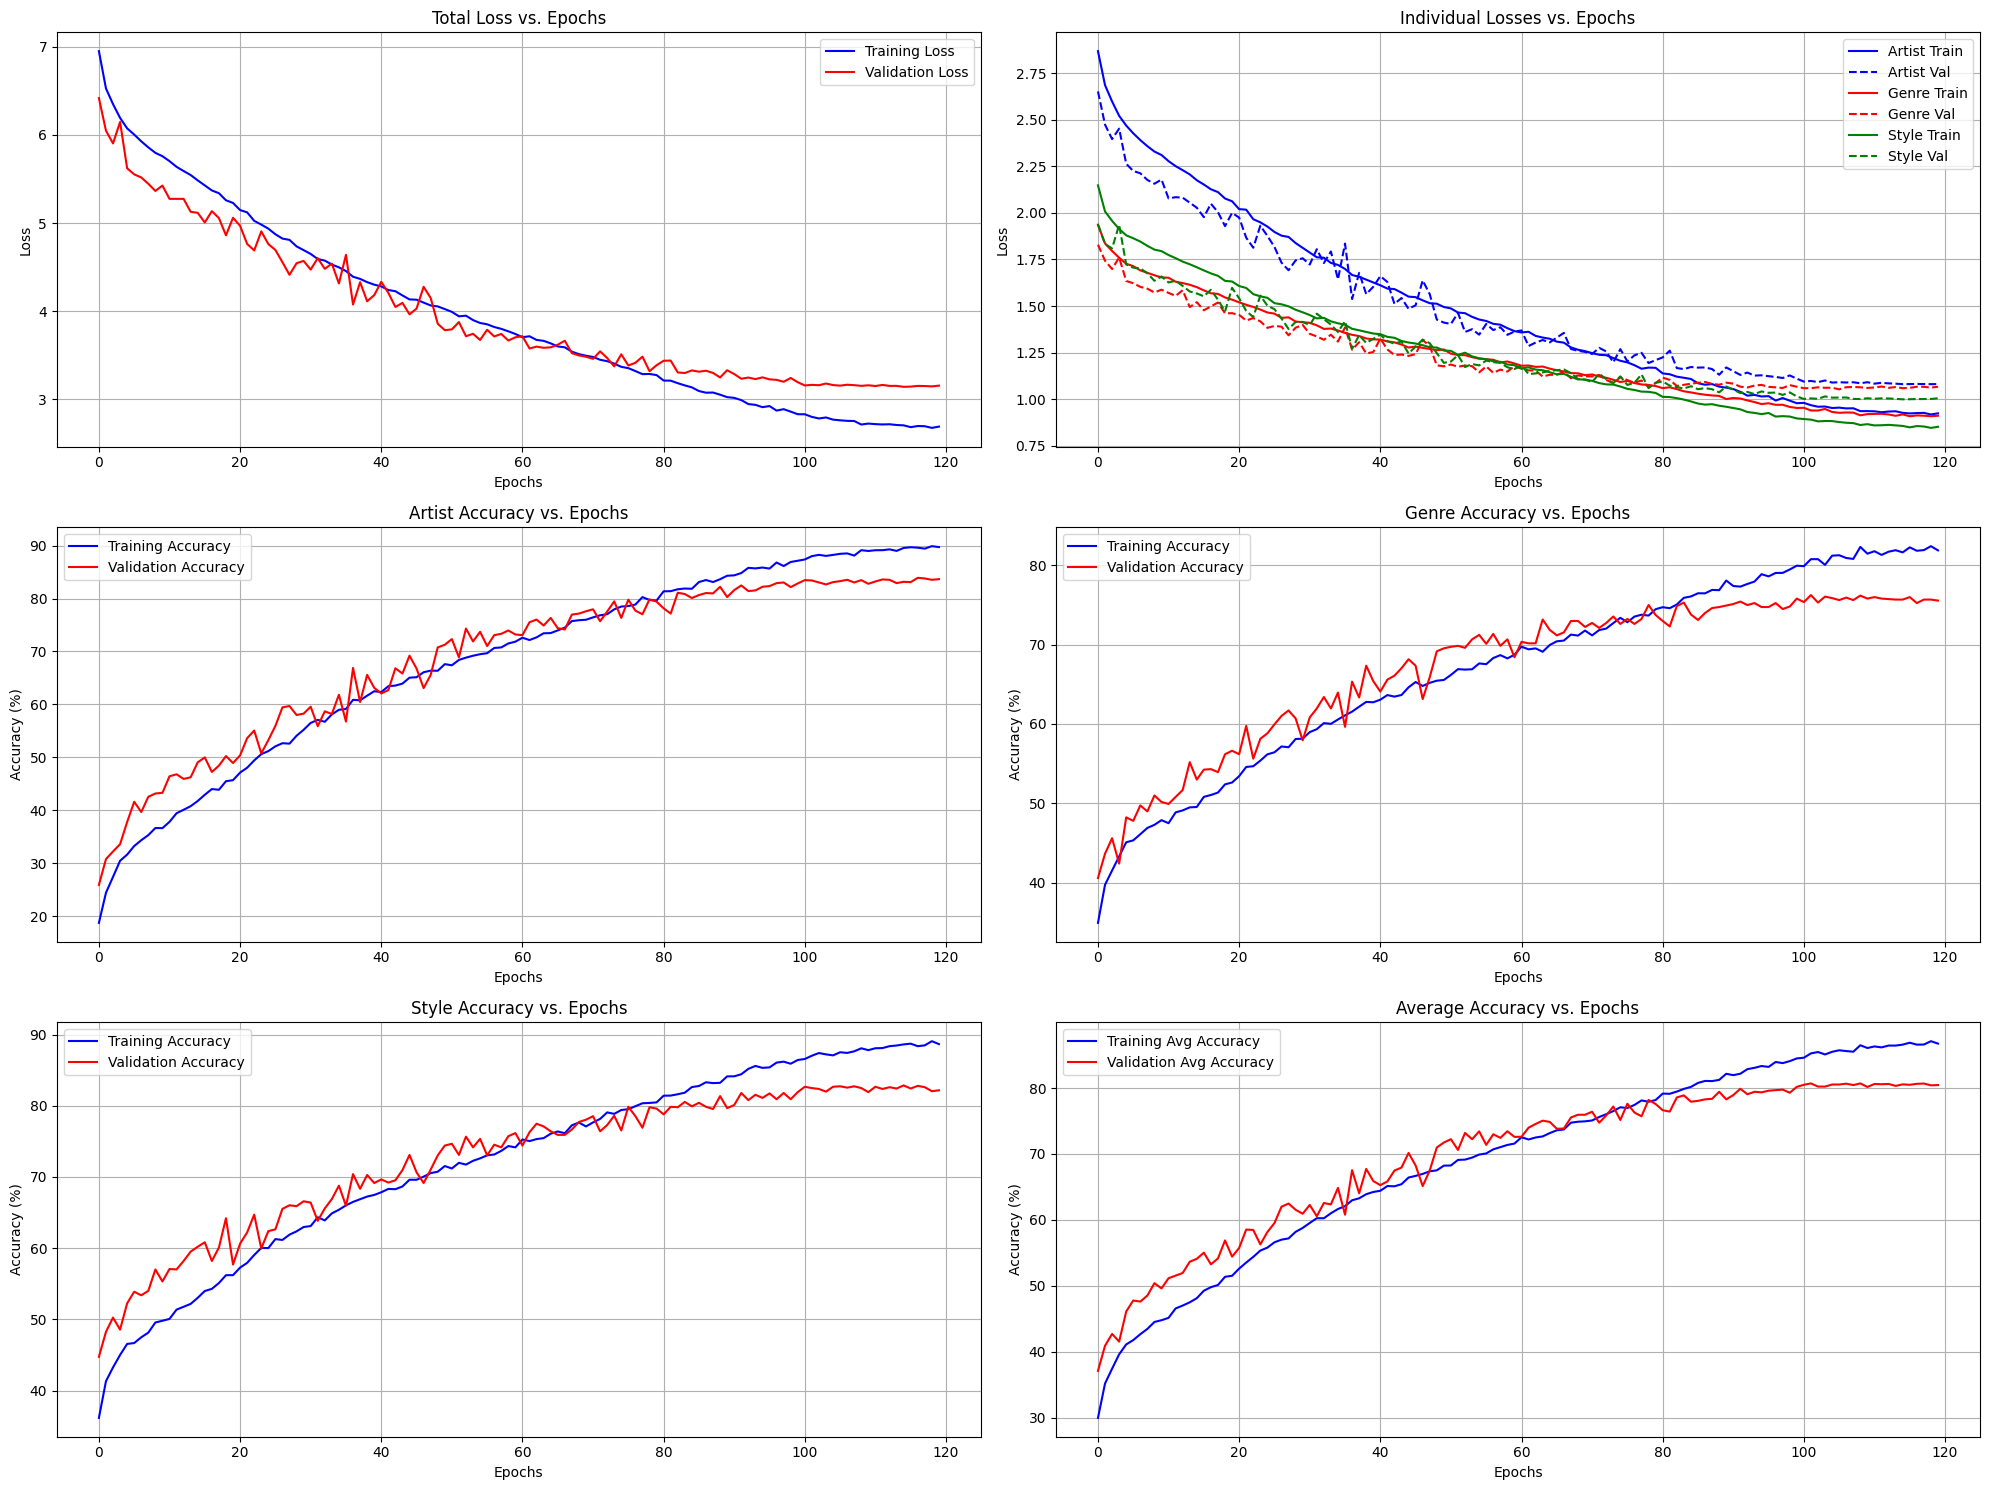

In [26]:
def plot_training_metrics(train_metrics, val_metrics):
    """
    Plot training and validation metrics over epochs.
    Args:
        train_metrics: Dictionary mapping epochs to training metric dictionaries
        val_metrics: Dictionary mapping epochs to validation metric dictionaries
    """
    epochs = sorted(train_metrics.keys())
    
    # Create a figure with multiple subplots
    plt.figure(figsize=(20, 15))
    
    # Plot total loss
    plt.subplot(3, 2, 1)
    plt.plot(epochs, [train_metrics[e]['loss'] for e in epochs], 'b-', label='Training Loss')
    plt.plot(epochs, [val_metrics[e]['loss'] for e in epochs], 'r-', label='Validation Loss')
    plt.title('Total Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    
    # Plot individual losses
    plt.subplot(3, 2, 2)
    plt.plot(epochs, [train_metrics[e]['artist_loss'] for e in epochs], 'b-', label='Artist Train')
    plt.plot(epochs, [val_metrics[e]['artist_loss'] for e in epochs], 'b--', label='Artist Val')
    plt.plot(epochs, [train_metrics[e]['genre_loss'] for e in epochs], 'r-', label='Genre Train')
    plt.plot(epochs, [val_metrics[e]['genre_loss'] for e in epochs], 'r--', label='Genre Val')
    plt.plot(epochs, [train_metrics[e]['style_loss'] for e in epochs], 'g-', label='Style Train')
    plt.plot(epochs, [val_metrics[e]['style_loss'] for e in epochs], 'g--', label='Style Val')
    plt.title('Individual Losses vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    
    # Plot artist accuracy
    plt.subplot(3, 2, 3)
    plt.plot(epochs, [train_metrics[e]['artist_acc1'] for e in epochs], 'b-', label='Training Accuracy')
    plt.plot(epochs, [val_metrics[e]['artist_acc1'] for e in epochs], 'r-', label='Validation Accuracy')
    plt.title('Artist Accuracy vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)
    plt.legend()
    
    # Plot genre accuracy
    plt.subplot(3, 2, 4)
    plt.plot(epochs, [train_metrics[e]['genre_acc1'] for e in epochs], 'b-', label='Training Accuracy')
    plt.plot(epochs, [val_metrics[e]['genre_acc1'] for e in epochs], 'r-', label='Validation Accuracy')
    plt.title('Genre Accuracy vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)
    plt.legend()

    # Plot style accuracy
    plt.subplot(3, 2, 5)
    plt.plot(epochs, [train_metrics[e]['style_acc1'] for e in epochs], 'b-', label='Training Accuracy')
    plt.plot(epochs, [val_metrics[e]['style_acc1'] for e in epochs], 'r-', label='Validation Accuracy')
    plt.title('Style Accuracy vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)
    plt.legend()
    
    # Plot average accuracy
    plt.subplot(3, 2, 6)
    train_avg = [(train_metrics[e]['artist_acc1'] + train_metrics[e]['genre_acc1'] + train_metrics[e]['style_acc1'])/3 for e in epochs]
    val_avg = [(val_metrics[e]['artist_acc1'] + val_metrics[e]['genre_acc1'] + val_metrics[e]['style_acc1'])/3 for e in epochs]
    plt.plot(epochs, train_avg, 'b-', label='Training Avg Accuracy')
    plt.plot(epochs, val_avg, 'r-', label='Validation Avg Accuracy')
    plt.title('Average Accuracy vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)
    plt.legend()
   
    # Adjust layout and save figure
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, 'training_metrics.png'))
    plt.show()

# After evaluation
print("Plotting training metrics...")
plot_training_metrics(train_metrics, val_metrics)

## Test Dataset Evaluation

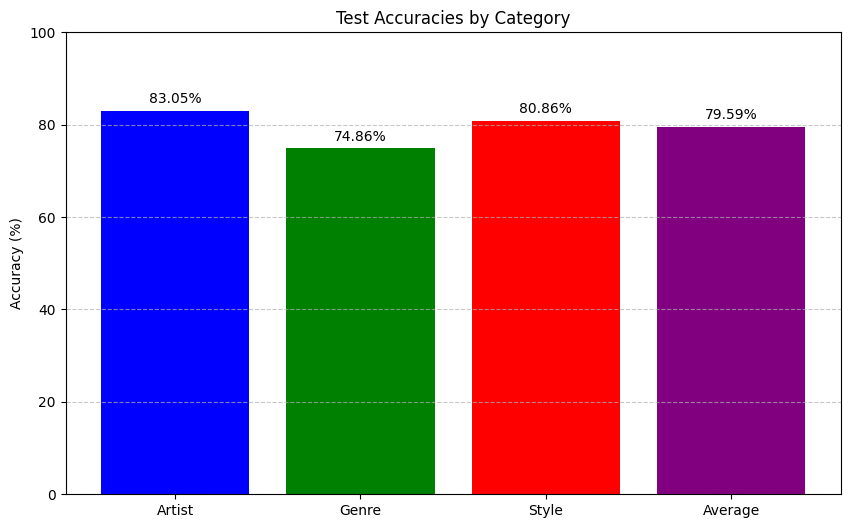


Model Performance Summary:
--------------------------------------------------------------------------------
Best Validation Accuracies:
  Artist: 83.42%
  Genre:  76.22%
  Style:  82.48%
  Average: 80.71%
--------------------------------------------------------------------------------
Final Test Accuracies:
  Artist: 83.05%
  Genre:  74.86%
  Style:  80.86%
  Average: 79.59%
--------------------------------------------------------------------------------
Training and evaluation complete.


In [27]:
# Create a bar chart to compare final test accuracies
def plot_test_accuracies(test_results):
   """
   Create a bar chart showing final test accuracies for all tasks.
   """
   plt.figure(figsize=(10, 6))
   
   categories = ['Artist', 'Genre', 'Style', 'Average']
   accuracies = [test_results['artist_acc'], test_results['genre_acc'], test_results['style_acc'], test_results['avg_acc']]
   
   bars = plt.bar(categories, accuracies, color=['blue', 'green', 'red', 'purple'])
   
   # Add accuracy values on top of each bar
   for bar in bars:
       height = bar.get_height()
       plt.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.2f}%', ha='center', va='bottom')
   
   plt.title('Test Accuracies by Category')
   plt.ylabel('Accuracy (%)')
   plt.ylim(0, 100)  # Set y-axis limits
   plt.grid(axis='y', linestyle='--', alpha=0.7)
   
   plt.savefig(os.path.join(save_path, 'test_accuracies.png'))
   plt.show()

# Plot test accuracies
plot_test_accuracies(test_results)

# Summary of model performance
print("\nModel Performance Summary:")
print("-" * 80)
print(f"Best Validation Accuracies:")
print(f"  Artist: {best_acc1['artist']:.2f}%")
print(f"  Genre:  {best_acc1['genre']:.2f}%")
print(f"  Style:  {best_acc1['style']:.2f}%")
print(f"  Average: {best_acc1['avg']:.2f}%")
print("-" * 80)
print(f"Final Test Accuracies:")
print(f"  Artist: {test_results['artist_acc']:.2f}%")
print(f"  Genre:  {test_results['genre_acc']:.2f}%")
print(f"  Style:  {test_results['style_acc']:.2f}%")
print(f"  Average: {test_results['avg_acc']:.2f}%")
print("-" * 80)

# Save a summary file
with open(os.path.join(save_path, 'model_summary.txt'), 'w') as f:
    f.write("Model Performance Summary:\n")
    f.write("-" * 80 + "\n")
    f.write(f"Best Validation Accuracies:\n")
    f.write(f"  Artist: {best_acc1['artist']:.2f}%\n")
    f.write(f"  Genre:  {best_acc1['genre']:.2f}%\n")
    f.write(f"  Style:  {best_acc1['style']:.2f}%\n")
    f.write(f"  Average: {best_acc1['avg']:.2f}%\n")
    f.write("-" * 80 + "\n")
    f.write(f"Final Test Accuracies:\n")
    f.write(f"  Artist: {test_results['artist_acc']:.2f}%\n")
    f.write(f"  Genre:  {test_results['genre_acc']:.2f}%\n")
    f.write(f"  Style:  {test_results['style_acc']:.2f}%\n")
    f.write(f"  Average: {test_results['avg_acc']:.2f}%\n")
    f.write("-" * 80 + "\n")
   
print("Training and evaluation complete.")